In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
from gensim.models import FastText
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv("Data/GamesDataClean.csv", usecols=["content", "score", "game_name"])
data = data.dropna()
subset = (
    data.groupby("game_name", group_keys=False)
        .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
        .reset_index(drop=True)
)
subset

C:\Users\Austin\AppData\Local\Temp\ipykernel_21672\3173297405.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))


,game_name,content,score
0,8 Ball Pool,fun cannot enjoy constantly try money take fun,1
1,8 Ball Pool,waste download waste time cue repeat cue 45 co...,1
2,8 Ball Pool,fun developer try persuade give money spin etc...,1
3,8 Ball Pool,say one thing probably best world whoever crea...,5
4,8 Ball Pool,problem give 1 star 1 win 2 back back total nu...,1
...,...,...,...
995,Shadow Fight 2,2 two much,2
996,Shadow Fight 2,nice guy multiplayer know shadow fight 3 4 2 3...,5
997,Shadow Fight 2,bring back lot memory remember well great lot see,5
998,Shadow Fight 2,ap many ad pay win,3


In [3]:
X = subset["content"].values
y = subset["score"].astype(int).values

In [4]:
tfidfContent = X

FastTextContent = []
for text in X:
    FastTextContent.append(text.split())

In [5]:
X_train_TF, X_test_TF, y_train_TF, y_test_TF = train_test_split(tfidfContent, y, test_size=0.2, random_state=42, stratify=y)
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(FastTextContent, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
if y_train_TF.min() == 1:
    y_train_TF = y_train_TF - 1
    y_test_TF  = y_test_TF  - 1
    y_train_FT = y_train_FT - 1
    y_test_FT  = y_test_FT  - 1

In [6]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)
X_train_TF = tfidf.fit_transform(X_train_TF)
X_test_TF = tfidf.transform(X_test_TF)

In [7]:
model_ft = FastText(
    sentences=X_train_FT,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=os.cpu_count(),
    epochs=10
)
ft = model_ft.wv

def avg_vector(tokens, model):
    words = [w for w in tokens if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

X_train_avg = np.array([avg_vector(t, model_ft) for t in X_train_FT])
X_test_avg = np.array([avg_vector(t, model_ft) for t in X_test_FT])

In [8]:
# --- Parameters ---
max_len = 200          
embed_dim = model_ft.vector_size 

# --- Word to vector sequence ---
def tokens_to_vectors(tokens, model, max_len):
    seq = []
    for w in tokens:
        if w in model.wv:
            seq.append(model.wv[w])
        else:
            seq.append(np.zeros(embed_dim))  # handle OOV
        if len(seq) >= max_len:
            break
    # pad to max_len
    if len(seq) < max_len:
        seq += [np.zeros(embed_dim)] * (max_len - len(seq))
    return np.array(seq)

X_train_seq = np.array([tokens_to_vectors(t, model_ft, max_len) for t in X_train_FT])
X_test_seq  = np.array([tokens_to_vectors(t, model_ft, max_len) for t in X_test_FT])

print("Train shape:", X_train_seq.shape)
print("Test shape :", X_test_seq.shape)

Train shape: (800, 200, 300)
Test shape : (200, 200, 300)


## Logistic Regression

In [10]:
lr_tfidf = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1
)
lr_tfidf.fit(X_train_TF, y_train_TF)
pred_TF_LR = lr_tfidf.predict(X_test_TF)

lr_ft = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1
)
lr_ft.fit(X_train_avg, y_train_FT)
pred_FT_LR = lr_ft.predict(X_test_avg)

c:\Users\Austin\anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Austin\anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## XGBoost Model

In [11]:
xgb_tfidf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_TF)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_tfidf.fit(X_train_TF, y_train_TF)
pred_TF_XGB = xgb_tfidf.predict(X_test_TF)

xgb_ft = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_FT)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_ft.fit(X_train_avg, y_train_FT)
pred_FT_XGB = xgb_ft.predict(X_test_avg)

## Bidirectional LSTM

In [12]:
inp = layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))  # (max_len, embed_dim)

x = layers.SpatialDropout1D(0.3)(inp)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(5, activation="softmax")(x)

FT_model = models.Model(inp, out)
FT_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
FT_model.summary()

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300)]        0         
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                             

In [13]:
ytr = np.asarray(y_train_FT)
yte = np.asarray(y_test_FT)

history = FT_model.fit(
    X_train_seq, ytr,
    validation_split=0.1,
    epochs=25,
    batch_size=256,
    callbacks=cbs,
    verbose=0
)

proba = FT_model.predict(X_test_seq, batch_size=256, verbose=0)
pred_FT_LSTM  = proba.argmax(axis=1)

In [14]:
results = {
    "Model": [
        "TF-IDF + Logistic Regression",
        "TF-IDF + XGBoost",
        "FastText (avg) + Logistic Regression",
        "FastText (avg) + XGBoost",
        "FastText (seq) + BiLSTM"
    ],
    "Accuracy": [
        accuracy_score(y_test_TF, pred_TF_LR),
        accuracy_score(y_test_TF, pred_TF_XGB),
        accuracy_score(y_test_FT, pred_FT_LR),
        accuracy_score(y_test_FT, pred_FT_XGB),
        accuracy_score(y_test_FT, pred_FT_LSTM)
    ],
    "Macro-F1": [
        f1_score(y_test_TF, pred_TF_LR, average="macro"),
        f1_score(y_test_TF, pred_TF_XGB, average="macro"),
        f1_score(y_test_FT, pred_FT_LR, average="macro"),
        f1_score(y_test_FT, pred_FT_XGB, average="macro"),
        f1_score(y_test_FT, pred_FT_LSTM, average="macro")
    ],
    "Weighted-F1": [
        f1_score(y_test_TF, pred_TF_LR, average="weighted"),
        f1_score(y_test_TF, pred_TF_XGB, average="weighted"),
        f1_score(y_test_FT, pred_FT_LR, average="weighted"),
        f1_score(y_test_FT, pred_FT_XGB, average="weighted"),
        f1_score(y_test_FT, pred_FT_LSTM, average="weighted")
    ]
}

df_results = pd.DataFrame(results)
df_results.round(4)

,Model,Accuracy,Macro-F1,Weighted-F1
0,TF-IDF + Logistic Regression,0.510,0.3545,0.4919
1,TF-IDF + XGBoost,0.500,0.2836,0.4303
2,FastText (avg) + Logistic Regression,0.240,0.2025,0.2320
3,FastText (avg) + XGBoost,0.490,0.2689,0.4271
4,FastText (seq) + BiLSTM,0.465,0.2133,0.3721


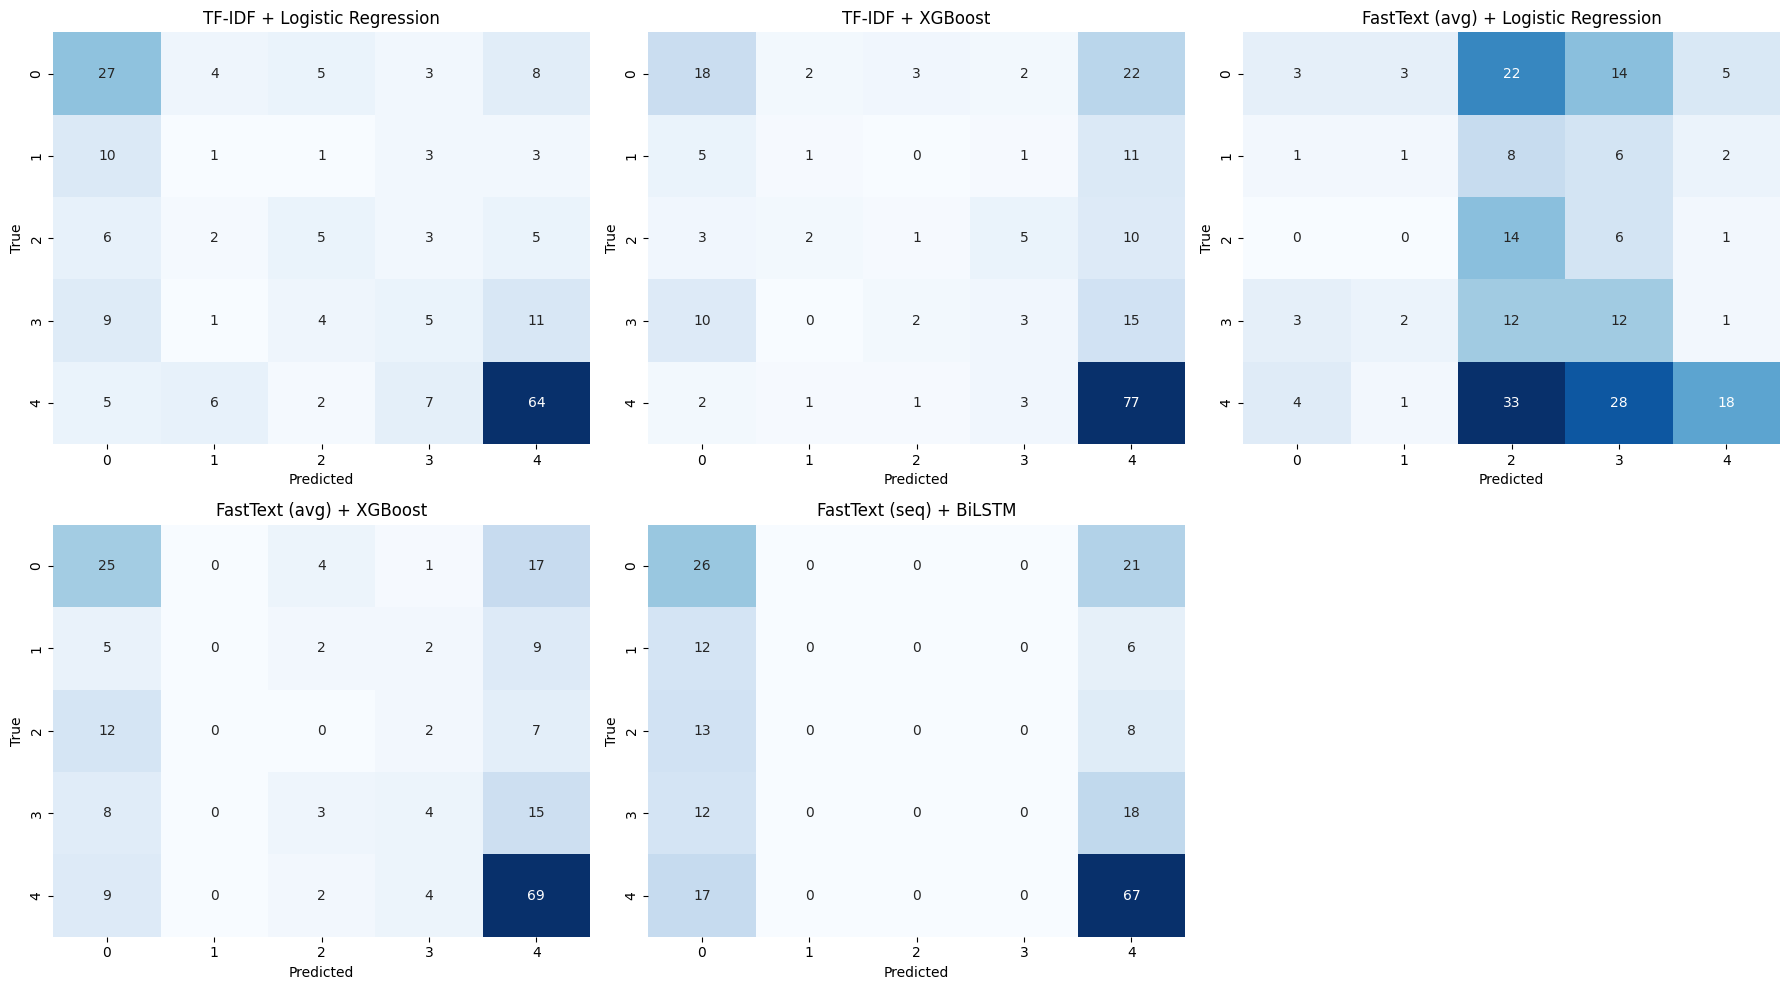

In [15]:
# --- Confusion Matrices ---
preds = [
    (pred_TF_LR, y_test_TF, "TF-IDF + Logistic Regression"),
    (pred_TF_XGB, y_test_TF, "TF-IDF + XGBoost"),
    (pred_FT_LR, y_test_FT, "FastText (avg) + Logistic Regression"),
    (pred_FT_XGB, y_test_FT, "FastText (avg) + XGBoost"),
    (pred_FT_LSTM, y_test_FT, "FastText (seq) + BiLSTM"),
]

# Determine number of classes automatically
num_classes = len(np.unique(y_test_TF))
class_labels = [str(i) for i in range(num_classes)]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (pred, y_true, title) in enumerate(preds):
    if i >= len(axes):  # safety check if fewer than 6 subplots
        break
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Hide extra subplot if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()